# 🧠 Plan du notebook - `06_inference.ipynb`

| Étape | Objectif                                                                                         |
| ----- | ------------------------------------------------------------------------------------------------ |
| 1     | ⚙️ Imports des librairies, configuration du `device`                                              |
| 2     | 🧠 Chargement du `tokenizer` (`tokenizer.pkl`)                                                    |
| 3     | 🧱 Chargement du `DecoderWithAttention` entraîné (`decoder.pt`)                                   |
| 4     | 🖼️ Définition du `Encoder` ResNet50 (si image brute utilisée)                                     |
| 5     | 🎨 Visualisation des résultats de l’Encoder (features + image)                                    |
| 6     | 🔍 Fonction de génération de légende `generate_caption()`                                        |
| 7     | 📥 Chargement d’une image test (du dataset ou externe)                                            |
| 8     | 🧠 Passage par l’encoder pour obtenir les `features`                                              |
| 9     | ✍️ Génération d’une légende à partir des features et du tokenizer                                 |
| 10    | 🖼️ Affichage de l’image + légende générée                                                         |
| 11    | 🧪 (optionnel) Génération de légendes pour plusieurs images en batch                              |
| 12    | 📊 (optionnel) Comparaison avec les `captions originales` et calcul BLEU/ROUGE (si disponibles)  |
| 13    | 🚀 (optionnel) Ajout d’une interface Gradio simple pour tester en drag & drop                     |


## ✅ Étape 1 — ⚙️ Imports des librairies + configuration du device

In [1]:
# 📦 Librairies standards
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# 🔥 PyTorch
import torch
from torchvision import transforms

# 📌 Ajoute le dossier racine du projet au PYTHONPATH
root_dir = Path().resolve().parent  # remonte d'un cran si ton notebook est dans `notebooks/`
sys.path.append(str(root_dir))

# 📦 Modules du projet
from src.model.decoder import DecoderWithAttention
from src.model.encoder import Encoder
from src.data.tokenizer import load_tokenizer


### 🔍 Explication

| Élément                | Rôle                                                                 |
| ---------------------- | -------------------------------------------------------------------- |
| `matplotlib`, `PIL`    | Affichage de l'image et chargement depuis `.jpg`                     |
| `torch`, `transforms`  | Traitement et normalisation des images pour ResNet                   |
| `DecoderWithAttention` | Ton modèle entraîné chargé pour l'inférence                          |
| `Encoder`              | Pour extraire dynamiquement les features à partir d'une image `.jpg` |
| `load_tokenizer`       | Pour transformer les `ids` en mots et inversement                    |


### ⚙️ Détection automatique du device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("📍 Device utilisé :", device)


📍 Device utilisé : cuda


## ✅ Étape 2 — 🧠 Chargement du `tokenizer` (`tokenizer.pkl`)

In [3]:
# 📍 Chemin vers le tokenizer sauvegardé
tokenizer_path = "../data/vocab/tokenizer.pkl"

# 📦 Chargement via la fonction utilitaire
tokenizer = load_tokenizer(tokenizer_path)

# ✅ Vérification rapide
print(f"🧠 Tokenizer chargé avec {len(tokenizer.word2idx)} tokens.")
print(f"🔤 Exemple : <start> = {tokenizer.start_token_id}, <end> = {tokenizer.end_token_id}")


🧠 Tokenizer chargé avec 4004 tokens.
🔤 Exemple : <start> = 1, <end> = 2


### 🔍 Explication

| Élément                          | Description                                                                 |
| -------------------------------- | --------------------------------------------------------------------------- |
| `tokenizer.pkl`                  | Fichier pickle sauvegardé lors du vocab building (avec les tokens spéciaux) |
| `load_tokenizer()`               | Fonction maison qui restaure un objet `Tokenizer`                           |
| `tokenizer.word2idx`             | Dictionnaire `{mot: index}`                                                 |
| `tokenizer.idx2word`             | Dictionnaire inverse `{index: mot}`                                         |
| `start_token_id`, `end_token_id` | Permettent de savoir quand commencer/terminer la génération                 |


### 🧪 Petit test possible :

In [4]:
# Test d'encodage puis de décodage
test = tokenizer.encode("a group of children playing soccer")
print("➡️ Encodé :", test)
print("⬅️ Décodé :", tokenizer.decode(test))

➡️ Encodé : [1, 4, 59, 13, 63, 35, 106, 2]
⬅️ Décodé : a group of children playing soccer


## ✅ Étape 3 — 🧱 Chargement du modèle entraîné (`decoder.pt`)

In [5]:
# 📍 Chemin vers le modèle entraîné (à adapter si besoin)
decoder_path = "../outputs/20250625_115742/decoder.pt"

# 📐 Paramètres à reproduire exactement comme à l'entraînement
attention_dim = 256
embed_dim = 256
decoder_dim = 512
dropout = 0.5
vocab_size = len(tokenizer.word2idx)

# 🧠 Instanciation du modèle
decoder = DecoderWithAttention(
    attention_dim=attention_dim,
    embed_dim=embed_dim,
    decoder_dim=decoder_dim,
    vocab_size=vocab_size,
    dropout=dropout
)

# 💾 Chargement des poids
decoder.load_state_dict(torch.load(decoder_path, map_location=device))
decoder = decoder.to(device)
decoder.eval()

print("✅ Modèle DecoderWithAttention chargé et prêt pour l'inférence.")


✅ Modèle DecoderWithAttention chargé et prêt pour l'inférence.


### 🔍 Explication

| Élément                     | Rôle                                                                                   |
| --------------------------- | -------------------------------------------------------------------------------------- |
| `decoder_path`              | Le fichier `.pt` sauvegardé lors du training                                           |
| `DecoderWithAttention(...)` | Il doit être instancié avec les **mêmes dimensions** qu’à l’entraînement               |
| `load_state_dict(...)`      | Charge les **poids** dans l’architecture vide                                          |
| `decoder.eval()`            | Indique à PyTorch qu’on est en **mode inférence** (désactive dropout, batchnorm, etc.) |


## ✅ Étape 4 — 🖼️ Définir l'Encoder ResNet50

In [6]:
# 🧠 Chargement de l’encoder ResNet50
encoder = Encoder().to(device)
encoder.eval()

# 🖼️ Image à encoder (depuis ton dataset ou extérieure)
image_path = Path("../data/raw/Flicker8k_Dataset/3338291921_fe7ae0c8f8.jpg")
image = Image.open(image_path).convert("RGB")

# 🔍 Extraction des features
features = encoder(image)         # (2048,)
features = features.unsqueeze(0)  # (1, 2048) pour compatibilité modèle
features = features.to(device)


## ✅ Étape 5 — 🎨 Visualisation des résultats de l’Encoder (features + image)

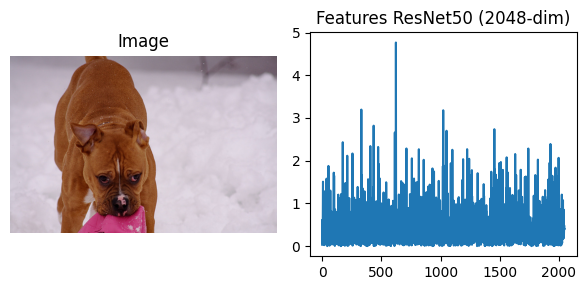

In [7]:
from src.model.encoder import Encoder  # si pas déjà importé

# 🧠 Instancier l'encoder
encoder = Encoder().to(device)
encoder.eval()

# 🖼️ Charger une image test
image_path = Path("../data/raw/Flicker8k_Dataset/3338291921_fe7ae0c8f8.jpg")
image = Image.open(image_path).convert("RGB")

# 🔍 Extraire les features
features = encoder(image)  # (2048,)
features = features.unsqueeze(0).to(device)  # (1, 2048)

# 📊 Affichage image + vecteur de features
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Image")

plt.subplot(1, 2, 2)
plt.plot(features.squeeze().cpu().numpy())
plt.title("Features ResNet50 (2048-dim)")
plt.tight_layout()
plt.show()


## 🔍 Étape 6 — Fonction de génération de légende `generate_caption()`

In [8]:
def generate_caption(decoder, image_features, tokenizer, max_len=20):
    decoder.eval()
    sampled_ids = []
    confidences = []

    inputs = torch.tensor([[tokenizer.start_token_id]]).to(image_features.device)

    hidden, cell = decoder.init_hidden_state(image_features)

    for _ in range(max_len):
        embeddings = decoder.embedding(inputs).squeeze(1)
        context, _ = decoder.attention(image_features, hidden)
        decoder_input = torch.cat([embeddings, context], dim=1)

        hidden, cell = decoder.decode_step(decoder_input, (hidden, cell))

        preds = decoder.fc(hidden)                # (1, vocab_size)
        probs = torch.softmax(preds, dim=1)       # Convert to probabilities
        predicted = preds.argmax(1)               # Most probable token
        confidence = probs[0, predicted.item()].item()

        sampled_ids.append(predicted.item())
        confidences.append(confidence)

        if predicted.item() == tokenizer.end_token_id:
            break

        inputs = predicted.unsqueeze(1)

    # Nettoyage
    words = [
        tokenizer.idx2word[idx]
        for idx in sampled_ids
        if idx not in {tokenizer.start_token_id, tokenizer.end_token_id, tokenizer.pad_token_id}
    ]
    filtered_conf = [
        conf for idx, conf in zip(sampled_ids, confidences)
        if idx not in {tokenizer.start_token_id, tokenizer.end_token_id, tokenizer.pad_token_id}
    ]

    return words, filtered_conf


### 🔍 Explication pas à pas
| Étape                     | Action                                                   |
| ------------------------- | -------------------------------------------------------- |
| `inputs`                  | Initialise avec `<start>`                                |
| `embedding`               | Embedding du token courant                               |
| `attention(...)`          | Calcule le vecteur de contexte depuis les features image |
| `decode_step(...)`        | Passe dans le LSTM                                       |
| `fc(...)`                 | Prédit les probabilités sur le vocabulaire               |
| `argmax`                  | Choisit le mot avec la proba la plus élevée              |
| `sampled_ids.append(...)` | Ajoute le mot généré                                     |
| `break if <end>`          | Arrête la génération si fin atteinte                     |
| `decode()`                | Convertit la liste d’ids en phrase texte                 |


## ✅ Étape 7 — 📥 Chargement d’une image test (depuis le dataset ou une image externe)

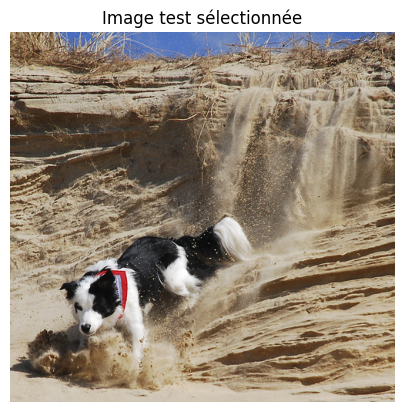

In [9]:
# 🖼️ Exemple d'image à tester (ici une image du dataset)
image_path = Path("../data/raw/Flicker8k_Dataset/2428275562_4bde2bc5ea.jpg")

# ✅ Chargement propre avec PIL
image = Image.open(image_path).convert("RGB")

# Vérification rapide
plt.imshow(image)
plt.axis("off")
plt.title("Image test sélectionnée")
plt.show()


In [10]:
# import json
# from pathlib import Path

# # 📁 Chemins
# images_dir = Path("../data/raw/Flicker8k_Dataset")
# json_path = Path("../data/processed/aligned_captions.json")

# from pathlib import Path

# # 📁 Chemins
# dataset_dir = Path("../data/raw/Flicker8k_Dataset")
# split_files = [
#     "../data/raw/Flickr8k_text/Flickr_8k.trainImages.txt",
#     "../data/raw/Flickr8k_text/Flickr_8k.testImages.txt",
#     "../data/raw/Flickr8k_text/Flickr_8k.devImages.txt"
# ]

# # 📋 Lecture de tous les noms d'images dans les fichiers .txt
# images_from_txt = set()

# for txt_file in split_files:
#     with open(txt_file, "r") as f:
#         for line in f:
#             image_name = line.strip()
#             if image_name:  # ignore les lignes vides
#                 images_from_txt.add(image_name)

# # 📁 Images réellement présentes dans le dossier
# images_in_dataset = set(p.name for p in dataset_dir.glob("*.jpg"))

# # ❌ Images mentionnées dans les fichiers .txt mais absentes du dossier
# missing_images = images_from_txt - images_in_dataset

# # 📊 Résultat
# print(f"Nombre d’images mentionnées dans les fichiers texte : {len(images_from_txt)}")
# print(f"Nombre d’images réellement présentes dans le dataset : {len(images_in_dataset)}")
# print(f"Nombre d’images manquantes dans le dataset : {len(missing_images)}")

# # 📄 Affichage (optionnel : les 20 premières)
# if missing_images:
#     print("\nImages manquantes :")
#     for name in sorted(missing_images)[:20]:
#         print("-", name)
# else:
#     print("✅ Toutes les images des fichiers texte sont bien présentes dans le dossier.")



In [11]:
# # 🧾 Chargement des noms d’images dans les fichiers .txt
# images_in_splits = set()
# for file in split_files:
#     with open(file, "r") as f:
#         for line in f:
#             image = line.strip()
#             if image:
#                 images_in_splits.add(image)

# # 📷 Toutes les images du dossier
# images_in_dataset = set(p.name for p in dataset_dir.glob("*.jpg"))

# # 🔎 Images présentes dans le dataset mais absentes des splits
# extra_images = images_in_dataset - images_in_splits

# # 📊 Résultat
# print(f"Nombre d’images non utilisées dans les fichiers de split : {len(extra_images)}\n")
# print("Liste des images non mentionnées (extrait) :")
# for name in sorted(extra_images):
#     print("-", name)

## ✅ Étape 8 — 🧠 Passage par l’encoder pour obtenir les features

In [12]:
# 🔍 Passage dans l'encoder pour extraire les features (2048-dim)
features = encoder(image)         # → (2048,)
features = features.unsqueeze(0)  # → (1, 2048) : batch size = 1
features = features.to(device)    # → sur le même device que le modèle

print("✅ Features extraites. Shape :", features.shape)


✅ Features extraites. Shape : torch.Size([1, 2048])


### 🔍 Explication

| Étape            | Rôle                                                                       |
| ---------------- | -------------------------------------------------------------------------- |
| `encoder(image)` | Appelle ta classe `Encoder` pour obtenir un vecteur de 2048 dim            |
| `.unsqueeze(0)`  | Ajoute une dimension batch (PyTorch attend toujours `(batch_size, ...)`)   |
| `.to(device)`    | Assure que les features sont sur le même device que le modèle (GPU ou CPU) |


In [13]:
# ✍️ Génération de la légende avec score de confiance
words, confidences = generate_caption(decoder, features, tokenizer)

# 📝 Reconstruire la phrase
generated_caption = " ".join(words)
print("📝 Légende générée :", generated_caption)

# 📊 Affichage des mots + confiance
print("\n🔍 Détail mot par mot :")
for word, conf in zip(words, confidences):
    print(f"{word:15} | confiance : {conf:.2%}")

# 📈 Score global (optionnel)
mean_conf = sum(confidences) / len(confidences)
print(f"\n📊 Score moyen de confiance : {mean_conf:.2%}")


📝 Légende générée : a black and white dog is running through a sand tunnel

🔍 Détail mot par mot :
a               | confiance : 90.28%
black           | confiance : 78.47%
and             | confiance : 98.23%
white           | confiance : 99.42%
dog             | confiance : 98.24%
is              | confiance : 37.64%
running         | confiance : 52.75%
through         | confiance : 31.87%
a               | confiance : 51.37%
sand            | confiance : 45.00%
tunnel          | confiance : 11.73%

📊 Score moyen de confiance : 63.18%


## ✅ Étape 10 — 🖼️ Affichage de l’image avec la légende générée

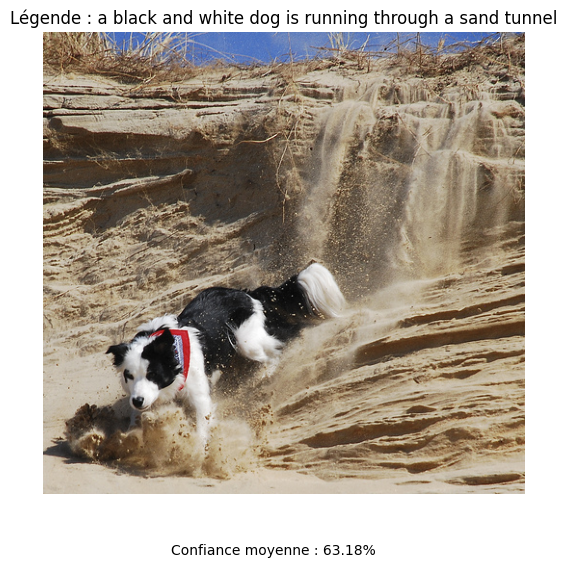

In [16]:
# 🖼️ Affichage de l'image + légende
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Légende : {generated_caption}", fontsize=12)
plt.figtext(0.5, 0.01, f"Confiance moyenne : {mean_conf:.2%}", ha='center', fontsize=10)
plt.show()
